In [1]:
import numpy as np
import sys
import os 
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import basinhopping, minimize, differential_evolution, dual_annealing

import matplotlib.patches as patches
from matplotlib.pyplot import cm

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

# from aodfunctions.dependencies import *
# from aodfunctions.general import *
# from aodfunctions.testbed import *
# from aodfunctions.settings import *

from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor

import ipyparallel as ipp



from scipy.special import binom, hyp2f1

def Bernstein_Poly(x, n, i):
    return np.where(x <= 1, binom(n,i) * x**i * (1-x)**(n-i),            # If x <= 1     
                    0)
def Int_Bernstein_Poly(x, n, i):
    return np.where(x <= 1, x**(i+1) * binom(n,i) * hyp2f1(i+1,i-n,i+2,x) / (i+1),            # If x <= 1     
                    1/(n+1))

def dBernstein_Poly(x, n, i):
    return binom(n,i) * (i-n*x) * x**(i-1) * (1-x)**(n-i-1)
def ddBernstein_Poly(x, n, i):
    return binom(n,i) * (i**2+(n-1)*n*x**2+i*(-1-2*(n-1)*x)) * x**(i-2) * (1-x)**(n-i-2)

def triangle_to_linear(row, col):
    return row*(row+1)/2 + col

def linear_to_triangle(linear):
    # Calculate the row using the quadratic formula
    row = int((np.sqrt(8*linear + 1) - 1) // 2)
    # Calculate the first linear index in that row
    start_of_row = row * (row + 1) // 2
    # Calculate the column
    col = linear - start_of_row
    return row, col

In [2]:
TRAP_DEPTH_MHz = 1e6 * 6.63e-34 #J for 1MHz trap
RB_MASS = 1.419E-25 #kg


## Setting constants
## time units are in us
## length units are in um
## mass units are in Rb mass
## trap depth/energy in units of Rb mass*(m/s)^2

F = 9000 #um This is almost the imaged AOD aperture diameter = 10,000 um
V = 650 * 10/7.5 #um/us The factor of 10/7.5 is from the imaging system from AOD to objective
M = 1
E0 = 40 * TRAP_DEPTH_MHz / RB_MASS #ideal trap depth
NA = 0.5
W = 1/np.pi/NA*0.8 #um
ZR = W/NA
LAMBDA = 0.8 #um
K = 2*np.pi/LAMBDA
AODaperture = 10000
N_pixel = 100  # What's the lowest number we can set this to be? 
T_delay = AODaperture/V


def backtract_beam_rad(waist,focal_length,wavelength):
    return focal_length * wavelength/(np.pi*waist)
def forward_focal_waist(radius,focal_length,wavelength):
    return focal_length * wavelength/(np.pi*radius)

XR=2500*1.5
rad_y = forward_focal_waist(XR,F,LAMBDA)
# L_range =  30 #um
# T_range = 121 #us
# dT = 0.1 #us

# t_list = np.arange(0,T_range+1e-6,dT)






In [3]:

def fourier_3D_potential(atom_loc,ideal_depth, Ac_list, AODaperture, XR, rad_y0):
    assert len(Ac_list) == N_pixel
    [x,y,z] = atom_loc
    # XR = backtract_beam_rad(rad_x0,F,LAMBDA)
    X_list = np.linspace(-AODaperture/2,AODaperture/2,N_pixel)
    A0_list = np.exp(-X_list**2/XR**2)
    A0_list /= sum(A0_list)
    temp1 = 1j* K* np.outer(X_list**2, z) /(2*F**2)
    temp2 = 1j*K*np.outer(X_list, x)/F
    temp3 = 1j*K*np.outer(Ac_list,(x+0.000001)/(x+0.000001))*V/F
    x_intensity_factor = abs(A0_list @ np.exp(temp1+temp2+temp3))**2 
    # x_intensity_factor = abs(sum(np.exp(temp1+temp2+temp3)))**2 / N_pixel**2
    rayleigh_y = np.pi*rad_y0**2/LAMBDA
    rad_y = rad_y0 * np.sqrt(1+(z/rayleigh_y)**2)
    y_intensity_factor = np.exp(-2*y**2/rad_y**2)*rad_y0/(rad_y)
    normalized_intensity = x_intensity_factor * y_intensity_factor
    return -ideal_depth * normalized_intensity

def fourier_3D_force_simp_and_slow(atom_loc,ideal_depth, Ac_list, AODaperture, XR, rad_y0):
    assert len(Ac_list) == N_pixel
    dx = 0.01
    atom_loc_dx = np.copy(atom_loc)
    atom_loc_dx[0] += dx
    atom_loc_dy = np.copy(atom_loc)
    atom_loc_dy[1] += dx
    atom_loc_dz = np.copy(atom_loc)
    atom_loc_dz[2] += dx
    Fx = (fourier_3D_potential(atom_loc,ideal_depth, Ac_list, AODaperture, XR, rad_y0)\
          - fourier_3D_potential(atom_loc_dx,ideal_depth, Ac_list, AODaperture, XR, rad_y0))/dx
    Fy = (fourier_3D_potential(atom_loc,ideal_depth, Ac_list, AODaperture, XR, rad_y0)\
          - fourier_3D_potential(atom_loc_dy,ideal_depth, Ac_list, AODaperture, XR, rad_y0))/dx
    Fz = (fourier_3D_potential(atom_loc,ideal_depth, Ac_list, AODaperture, XR, rad_y0)\
          - fourier_3D_potential(atom_loc_dz,ideal_depth, Ac_list, AODaperture, XR, rad_y0))/dx
    return np.array([Fx,Fy,Fz])

def fourier_3D_force(atom_loc,ideal_depth, Ac_list, AODaperture, XR, rad_y0):
    assert len(Ac_list) == N_pixel
    [x,y,z] = atom_loc
    # XR = backtract_beam_rad(rad_x0,F,LAMBDA)
    X_list = np.linspace(-AODaperture/2,AODaperture/2,N_pixel)
    A0_list = np.exp(-X_list**2/XR**2)
    A0_list /= sum(A0_list)
    rayleigh_y = np.pi*rad_y0**2/LAMBDA
    rad_y = rad_y0 * np.sqrt(1+(z/rayleigh_y)**2)
    y_intensity_factor = np.exp(-2*y**2/rad_y**2)*rad_y0/(rad_y)

    temp1 = 1j* K* np.outer(X_list**2, z) /(2*F**2)
    temp2 = 1j*K*np.outer(X_list, x)/F
    # temp3 = 1j*K*np.outer(Ac_list,np.ones(len(x)))*V/F
    temp3 = 1j*K*np.outer(Ac_list,(x+1.234321)/(x+1.234321))*V/F
    fourier_factor = np.exp(temp1+temp2+temp3) # shape of (N_pixel, N_particle)
    x_amp_factor = A0_list @ fourier_factor # shape of ( N_particle)
    x_intensity_factor = abs(x_amp_factor)**2  # shape of ( N_particle)
    normalized_intensity = x_intensity_factor * y_intensity_factor # shape of ( N_particle)
    
    x_grad_factor = np.conj(1j*K/F * np.einsum('i,i,ij->j', A0_list, X_list, fourier_factor))   # shape of ( N_particle)
    normalized_force_x = 2* np.real(x_amp_factor*x_grad_factor) * y_intensity_factor  # shape of ( N_particle)

    normalized_force_y = -normalized_intensity * (4*y/rad_y**2) # shape of ( N_particle)

    temp_A = z/(rayleigh_y**2+z**2)*(1-4*y**2/rad_y**2) 
    z_grad_factor = np.conj(1j*K/F**2/2 * np.einsum('i,i,ij->j', A0_list, X_list**2, fourier_factor))  
    normalized_force_z = -normalized_intensity * temp_A + y_intensity_factor * 2 * np.real(x_amp_factor*z_grad_factor)

    return ideal_depth * np.array([normalized_force_x,normalized_force_y,normalized_force_z])




fourier_force = fourier_3D_force
fourier_potential = fourier_3D_potential

In [4]:

def kinetic_energy(phase_vec):
    v_vec = phase_vec[-3:]
    return (M/2) * np.sum(v_vec**2, axis=0)

def kinetic_energy_movframe(phase_vec,vc_vec):
    v_vec = phase_vec[-3:]
    return (M/2) * np.sum((v_vec-vc_vec)**2, axis=0)


def potential_energy(t, phase_vec,coeff):
    r_vec = phase_vec[:3]
    Ac_list = Ac_func(np.linspace(t,t-T_delay,N_pixel),coeff)
    return fourier_potential(r_vec,E0,Ac_list, AODaperture, XR, rad_y)

def potential_energy_t0(phase_vec):
    r_vec = phase_vec[:3]
    Ac_list = np.zeros(N_pixel)
    # Ac_list = Ac_func(np.linspace(0,0-T_delay,N_pixel))
    return fourier_potential(r_vec, E0, Ac_list, AODaperture, XR, rad_y)

def total_energy_movframe(t, phase_vec,coeff):
    arr = dxc_func(t,coeff)
    # arr = dxc_func(t)
    try:
        vc_vec = np.vstack((arr, np.zeros((2, arr.shape[0]))))
    except:
        vc_vec = np.array([arr,0,0])
    # print(f"kinetic shape = {kinetic_energy_movframe(phase_vec, vc_vec)[0].shape}")
    # print(f"potential shape = {potential_energy(t, phase_vec, coeff)[0].shape}")
    return kinetic_energy_movframe(phase_vec, vc_vec) + potential_energy(t, phase_vec, coeff)

def total_energy(t, phase_vec,coeff):
    return kinetic_energy(phase_vec) + potential_energy(t, phase_vec,coeff)

def total_energy_t0(phase_vec):
    return kinetic_energy(phase_vec) + potential_energy_t0(phase_vec)

########################## for sinesq ramp base ###########################
def xc_func_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, (1-np.cos(x*np.pi))/2 * L_range,         # If 0 < x < 1, return middle part
                    L_range))                # If x >= 1, return end part
def dxc_func_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, np.pi/2*np.sin(x*np.pi) * (L_range/T_range),         # If 0 < x < 1, return middle part
                    0))                # If x >= 1, return end part
def Ac_func_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, (x/2 - np.sin(np.pi*x)/(2*np.pi)) * T_range*L_range,         # If 0 < x < 1, return middle part
                    (x - 0.5) * T_range*L_range))                # If x >= 1, return end part


########################## for expansion perturbation using Bernstein Polynomials #########################
def xc_expand(t,n,HIGHEST_ORDER):
    x = t/T_range
    n_split = HIGHEST_ORDER+1
    return Bernstein_Poly(x, n_split, n) * L_range
def Ac_expand(t,n,HIGHEST_ORDER):
    x = t/T_range
    n_split = HIGHEST_ORDER+1
    return Int_Bernstein_Poly(x, n_split, n) * (L_range*T_range)
def dxc_expand(t,n,HIGHEST_ORDER):
    x = t/T_range
    n_split = HIGHEST_ORDER+1
    return dBernstein_Poly(x, n_split, n) * (L_range/T_range)

########################## for expansion perturbation using Bernstein Polynomials (truncated triangle) #########################
def xc_expand(t,n,HIGHEST_DEGREE):
    x = t/T_range
    row, col = linear_to_triangle(n)
    d = row + 2
    i = col + 1
    # print([d,i])
    assert d<= HIGHEST_DEGREE
    return Bernstein_Poly(x, d, i) * L_range
def Ac_expand(t,n,HIGHEST_DEGREE):
    x = t/T_range
    row, col = linear_to_triangle(n)
    d = row + 2
    i = col + 1
    assert d<= HIGHEST_DEGREE
    return Int_Bernstein_Poly(x, d, i) * (L_range*T_range)
def dxc_expand(t,n,HIGHEST_DEGREE):
    x = t/T_range
    row, col = linear_to_triangle(n)
    d = row + 2
    i = col + 1
    assert d<= HIGHEST_DEGREE
    return dBernstein_Poly(x, d, i) * (L_range/T_range)
######################################################################################################################

def Ac_func(t,coeff):
    # assert len(coeff) == HIGHEST_ORDER
    HIGHEST_ORDER = len(coeff)
    HIGHEST_DEGREE = int((-1 + np.sqrt(1 + 8 * HIGHEST_ORDER)) / 2) + 1
    assert (HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2 == HIGHEST_ORDER
    func_array = np.array([Ac_expand(t,n,HIGHEST_DEGREE) for n in range(0, HIGHEST_ORDER)])
    return coeff @ func_array +  Ac_func_base(t)
def xc_func(t,coeff):
    # assert len(coeff) == HIGHEST_ORDER
    HIGHEST_ORDER = len(coeff)
    HIGHEST_DEGREE = int((-1 + np.sqrt(1 + 8 * HIGHEST_ORDER)) / 2) + 1
    assert (HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2 == HIGHEST_ORDER
    func_array = np.array([xc_expand(t,n,HIGHEST_DEGREE) for n in range(0, HIGHEST_ORDER)])
    return coeff @ func_array +  xc_func_base(t)
def dxc_func(t,coeff):
    # assert len(coeff) == HIGHEST_ORDER
    HIGHEST_ORDER = len(coeff)
    HIGHEST_DEGREE = int((-1 + np.sqrt(1 + 8 * HIGHEST_ORDER)) / 2) + 1
    assert (HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2 == HIGHEST_ORDER
    func_array = np.array([dxc_expand(t,n,HIGHEST_DEGREE) for n in range(0, HIGHEST_ORDER)])
    return coeff @ func_array + dxc_func_base(t)

fourier_force = fourier_3D_force
fourier_potential = fourier_3D_potential

def time_derivative(t, phase_vec, coeff):
    # phase_vec = [x,y,z,vx,vy,vz]
    # potential_force_func(t, atom_loc)
    # fictitious_force_func(t)
    if len(phase_vec.shape) == 1 and phase_vec.shape == 6:
        r_vec = phase_vec[:3]
        v_vec = phase_vec[-3:]
        Ac_list = Ac_func(np.linspace(t,t-T_delay,N_pixel),coeff)
        potential_force = fourier_force(r_vec, E0, Ac_list, AODaperture, XR, rad_y)
        a_vec = (1/M) * potential_force
        return np.concatenate([v_vec,a_vec])
    elif len(phase_vec.shape) == 2 and phase_vec.shape[0] == 6:
        k = phase_vec.shape[-1]
        r_vec = phase_vec[:3]
        v_vec = phase_vec[-3:]
        Ac_list = Ac_func(np.linspace(t,t-T_delay,N_pixel),coeff)
        potential_force = fourier_force(r_vec, E0, Ac_list, AODaperture, XR, rad_y)
        a_vec = (1/M) * potential_force
        return np.concatenate([v_vec,a_vec])
    elif phase_vec.shape[0] % 6 == 0:
        # print("vectorized")
        k = phase_vec.shape[0] // 6
        r_vec = phase_vec[0:3*k].reshape(3,k)
        v_vec = phase_vec[-3*k:].reshape(3,k)
        Ac_list = Ac_func(np.linspace(t,t-T_delay,N_pixel),coeff)
        potential_force = fourier_force(r_vec, E0, Ac_list, AODaperture, XR, rad_y)
        a_vec = (1/M) * potential_force
        return np.concatenate([v_vec.ravel(),a_vec.ravel()])
    else:
        print(f"phase_vec shape= {phase_vec.shape} incorrect!")
        return 

6
[0, 0]


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


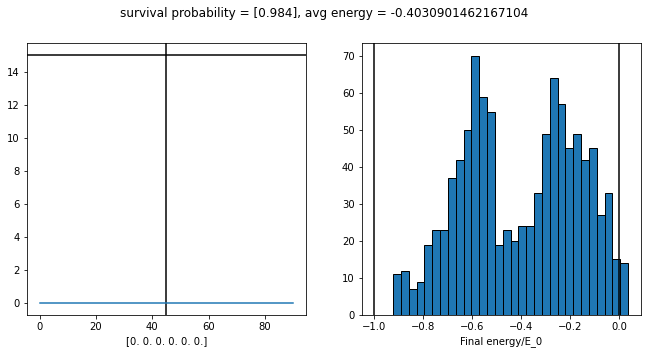

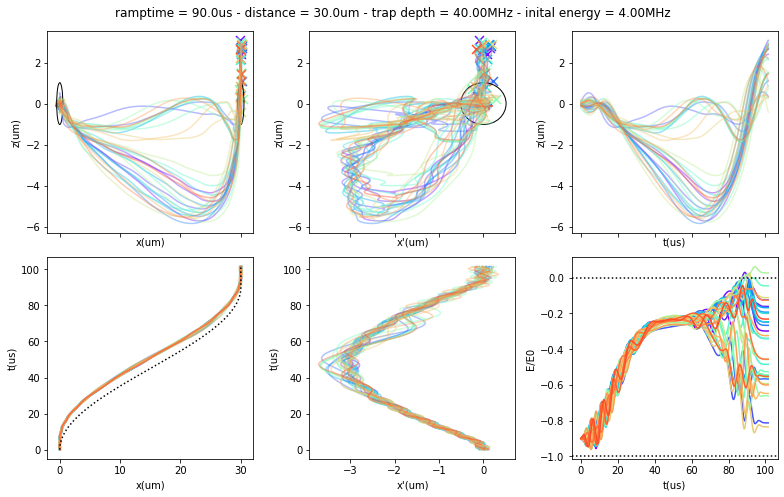

In [8]:
L_range = 30
plot_ramp = True
plot_trajectory = True
plot_histogram = False
N_particle = 1000
HIGHEST_DEGREE = 4
HIGHEST_ORDER = int((HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2)

T_range_list = np.linspace(90,150,1) #us
sinc_order_list = [np.zeros(HIGHEST_ORDER)]

phase_vec_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
t_vec_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
energies_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
survival_array = np.zeros((len(T_range_list),len(sinc_order_list)))
energy_avg_array = np.zeros((len(T_range_list),len(sinc_order_list)))
energy_std_array = np.zeros((len(T_range_list),len(sinc_order_list)))

init_temp = E0/10

for ii,T_range in enumerate(T_range_list):
    t_list = np.linspace(0,T_range,1000)
    for jj,expand_param in enumerate(sinc_order_list):
        HIGHEST_ORDER = len(expand_param)
        print(HIGHEST_ORDER)
        ##################################################################
        phase_vec_list = []
        t_vec_list = []

        ###################### vectorized simulation #####################
        init_vec = np.random.normal(0, np.sqrt(init_temp/3), (6,N_particle))
        init_vec[0:2] = init_vec[0:2]/np.sqrt(4*E0/W**2)
        init_vec[3] = init_vec[3]/np.sqrt(2*E0/ZR**2)
        init_vec[3:6] = init_vec[3:6]/np.sqrt(M)

        real_E = np.stack((total_energy_t0(init_vec),) * 6, axis=-1).T
        normalize_factor = init_temp/(real_E+E0)
        # print(normalize_factor.shape)
        # comment out the next line if use boltzmann distribution
        init_vec *= np.sqrt(normalize_factor)  
        init_vec_flattened = init_vec.ravel()
        t_eval = np.linspace(0,T_range+T_delay,1000)
        sol1=solve_ivp(time_derivative, [0,T_range+T_delay], init_vec_flattened,\
                        method='RK45', args=[expand_param], vectorized=True, t_eval=t_eval) #, maxes_step=.1)
        phase_vec_list = sol1.y.reshape(6,N_particle,-1).transpose(1, 0, 2)
        t_vec = sol1.t
        solutions = sol1.y.reshape(6,N_particle,-1) # [phase_vec_ind, particle_num, time]
        # energy_t = np.array([total_energy_movframe(sol1.t, solutions[:,ii] ,expand_param)/E0 for ii in range(N_particle)])
        # print(energy_t.shape)
        energy_list = np.array([total_energy_movframe(sol1.t[-1], phase_vec_list[jj,:,-1] ,expand_param)/E0 for jj in range(N_particle)])
        # print(energy_list.shape)
        # print(energy_list[0].shape)
        energies_array[ii,jj] = energy_list

        energy_std = np.std(energy_list)
        energy_avg = np.mean(energy_list)

        survival = sum(energy_list<0)/len(energy_list)

        energy_std_array[ii,jj] = energy_std
        energy_avg_array[ii,jj] = energy_avg
        survival_array[ii,jj] = survival
        phase_vec_array[ii,jj] = phase_vec_list
        t_vec_array[ii,jj] = t_vec_list
        
        print([ii,jj])
        if plot_ramp:
            fig, axes =plt.subplots(1,2,figsize=(11,5),sharex=False,sharey=False, squeeze=False)
            # plt.title(n)
            axes[0,0].axvline(T_range/2,color='k')
            axes[0,0].axhline(L_range/2,color='k')
            # axes[0,0].plot(t_list, xc_func(t_list,expand_param))
            # axes[0,0].plot(t_list, xc_func_base(t_list),ls="--",c='k')
            axes[0,0].plot(t_list, xc_func(t_list,expand_param)- xc_func_base(t_list))
            fig.suptitle(f"survival probability = {survival}, avg energy = {energy_avg}")
            axes[0,0].set_xlabel(expand_param)

            
            axes[0,1].axvline(-1,color='k')
            axes[0,1].axvline(0,color='k')
            axes[0,1].hist(energy_list, bins=30, edgecolor='black')
            # plt.title(f"survival probability = {survival}, avg energy = {energy_avg}")
            # plt.xlabel(expand_param)
            axes[0,1].set_xlabel('Final energy/E_0')
            plt.show()

        if plot_trajectory:
            n=N_particle//30
            # Create a figure and a set of subplots
            fig, axes = plt.subplots(2,3,figsize=(11,7),sharex='col',sharey=False)
            fig.suptitle(f"ramptime = {T_range:.1f}us - distance = {L_range:.1f}um - trap depth = {E0/(TRAP_DEPTH_MHz / RB_MASS):.2f}MHz - inital energy = {init_temp/(TRAP_DEPTH_MHz / RB_MASS):.2f}MHz")

            for ax in axes[0, :]:
                ax.sharey(axes[0, 0])


            color = cm.rainbow(np.linspace(0, 0.9, n))

            for i,phase_vec in enumerate(phase_vec_list[:n]):
                axes[0,0].plot(phase_vec[0],phase_vec[2],color=color[i],alpha=0.4)
                axes[0,0].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                axes[0,0].scatter(phase_vec[0,-1],phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,0].set_xlabel("x(um)")
                axes[0,0].set_ylabel("z(um)")
                axes[1,0].plot(phase_vec[0],t_vec,color=color[i],alpha=0.4)
                axes[1,0].set_xlabel("x(um)")
                axes[1,0].set_ylabel("t(us)")
                # axes[0,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),phase_vec[2],color=color[i],alpha=0.4)
                # axes[0,1].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                # axes[0,1].scatter(phase_vec[0,-1]-xc_func(t_vec[-1],expand_param),phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,1].scatter(phase_vec[0,-1]-xc_func(t_vec[-1],expand_param),phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),phase_vec[2],color=color[i],alpha=0.4)
                axes[0,1].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                axes[0,1].set_xlabel("x'(um)")
                axes[0,1].set_ylabel("z(um)")
                axes[1,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),t_vec,color=color[i],alpha=0.4)
                # axes[1,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),t_vec,color=color[i],alpha=0.4)
                axes[1,1].set_xlabel("x'(um)")
                axes[1,1].set_ylabel("t(us)")
                axes[0,2].plot(t_vec,phase_vec[2],color=color[i],alpha=0.4)
                axes[0,2].set_xlabel("t(us)")
                axes[0,2].set_ylabel("z(um)")
                # print(t_vec.shape)
                # print(phase_vec.shape)
                axes[1,2].plot(t_vec, [total_energy_movframe(t_vec[tt], phase_vec[:,tt], expand_param)/E0 for tt in range(len(t_vec))], color=color[i])
                
            axes[1,0].plot(xc_func(t_vec,expand_param), t_vec, color="k",ls=":")
            # axes[0,2].plot(t_vec, Zx_func(t_vec,expand_param),color="k",ls=":")
            # axes[0,2].plot(t_vec, Zx_func(t_vec,expand_param),color="k",ls=":")
            axes[1,2].axhline(0, color="k",ls=":")
            axes[1,2].axhline(-1, color="k",ls=":")
            axes[1,2].set_xlabel("t(us)")
            axes[1,2].set_ylabel("E/E0")
            
            # Define the center of the oval, width, and height
            center_x, center_y = 0,0
            width, height = 2*W,2*ZR
            # Create an ellipse patch
            ellipse = patches.Ellipse((center_x, center_y), width, height, edgecolor='black', facecolor='none')
            ellipse1 = patches.Ellipse((center_x+L_range, center_y), width, height, edgecolor='black', facecolor='none')
            ellipse2 = patches.Ellipse((center_x, center_y), width, height, edgecolor='black', facecolor='none')

            # Add the ellipse to the plot
            axes[0,0].add_patch(ellipse)
            axes[0,0].add_patch(ellipse1)
            # axes[0,0].axhline(Zx_func(T_range/2,expand_param),color="k",ls=":")
            # axes[0,0].plot(xc_func(t_vec,expand_param), Zx_func(t_vec,expand_param),color="k",ls=":")
            axes[0,1].add_patch(ellipse2)
            # axes[0,1].axhline(Zx_func(T_range/2,expand_param),color="k",ls=":")

            plt.tight_layout()
            plt.show()

        # energy_list = np.array([total_energy(t_vec, phase_vec_list[i],expand_param)[-1]/E0 for i in range(len(t_vec_list))])


        if plot_histogram:
            plt.figure()
            # plt.title(n)
            plt.axvline(-1,color='k')
            plt.axvline(0,color='k')
            plt.hist(energy_list, bins=30, edgecolor='black')
            plt.title(f"survival probability = {survival}, avg energy = {energy_avg}")
            # plt.xlabel(expand_param)
            plt.xlabel('Final energy/E_0')
            plt.show()
        
            
        #################################################################################

# print(f"survival probability = {sum(energy_list<0)/len(energy_list)}")

In [6]:



def loss_func(expand_param, N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, temp_or_surv):
    #####################################################################
    # expand_param: the expansion coefficients on the selected base functions
    # N_particle: number of monte carlo simulations done in a batch
    # init_temp_coeff: initial particle energy, either Bolzmann or thin-shell distribution
    # T_range: ramp time in us
    # L_range: ramp distance in um
    # temp_or_surv: use 0 for optimizing final temperature; i for optimizing final survival; in between for weighted both
    #######################################################################
    
    init_temp = E0 * init_temp_coeff
    ########################## for sinesq ramp base ###########################
    def xc_func_base(t):
        x = t/T_range
        return np.where(x <= 0, 0,            # If x <= 0, return 0
            np.where(x < 1, (1-np.cos(x*np.pi))/2 * L_range,         # If 0 < x < 1, return middle part
                        L_range))                # If x >= 1, return end part
    def dxc_func_base(t):
        x = t/T_range
        return np.where(x <= 0, 0,            # If x <= 0, return 0
            np.where(x < 1, np.pi/2*np.sin(x*np.pi) * (L_range/T_range),         # If 0 < x < 1, return middle part
                        0))                # If x >= 1, return end part
    def Ac_func_base(t):
        x = t/T_range
        return np.where(x <= 0, 0,            # If x <= 0, return 0
            np.where(x < 1, (x/2 - np.sin(np.pi*x)/(2*np.pi)) * T_range*L_range,         # If 0 < x < 1, return middle part
                        (x - 0.5) * T_range*L_range))                # If x >= 1, return end part

    ######################################################################
    ########################## for expansion perturbation using Bernstein Polynomials (truncated triangle) #########################
    def xc_expand(t,n,HIGHEST_DEGREE):
        x = t/T_range
        row, col = linear_to_triangle(n)
        d = row + 2
        i = col + 1
        # print([d,i])
        assert d<= HIGHEST_DEGREE
        return Bernstein_Poly(x, d, i) * L_range
    def Ac_expand(t,n,HIGHEST_DEGREE):
        x = t/T_range
        row, col = linear_to_triangle(n)
        d = row + 2
        i = col + 1
        assert d<= HIGHEST_DEGREE
        return Int_Bernstein_Poly(x, d, i) * (L_range*T_range)
    def dxc_expand(t,n,HIGHEST_DEGREE):
        x = t/T_range
        row, col = linear_to_triangle(n)
        d = row + 2
        i = col + 1
        assert d<= HIGHEST_DEGREE
        return dBernstein_Poly(x, d, i) * (L_range/T_range)
    ######################################################################################################################

    def Ac_func(t,coeff):
        # assert len(coeff) == HIGHEST_ORDER
        HIGHEST_ORDER = len(coeff)
        assert (HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2 == HIGHEST_ORDER
        func_array = np.array([Ac_expand(t,n,HIGHEST_DEGREE) for n in range(0, HIGHEST_ORDER)])
        return coeff @ func_array +  Ac_func_base(t)
    def xc_func(t,coeff):
        # assert len(coeff) == HIGHEST_ORDER
        HIGHEST_ORDER = len(coeff)
        assert (HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2 == HIGHEST_ORDER
        func_array = np.array([xc_expand(t,n,HIGHEST_DEGREE) for n in range(0, HIGHEST_ORDER)])
        return coeff @ func_array +  xc_func_base(t)
    def dxc_func(t,coeff):
        # assert len(coeff) == HIGHEST_ORDER
        HIGHEST_ORDER = len(coeff)
        assert (HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2 == HIGHEST_ORDER
        func_array = np.array([dxc_expand(t,n,HIGHEST_DEGREE) for n in range(0, HIGHEST_ORDER)])
        return coeff @ func_array + dxc_func_base(t)

    ###########################################################################3

    fourier_force = fourier_3D_force
    fourier_potential = fourier_3D_potential

    def time_derivative(t, phase_vec, coeff):
        # phase_vec = [x,y,z,vx,vy,vz]
        if len(phase_vec.shape) == 1 and phase_vec.shape == 6:
            r_vec = phase_vec[:3]
            v_vec = phase_vec[-3:]
            Ac_list = Ac_func(np.linspace(t,t-T_delay,N_pixel),coeff)
            potential_force = fourier_force(r_vec, E0, Ac_list, AODaperture, XR, rad_y)
            a_vec = (1/M) * potential_force
            return np.concatenate([v_vec,a_vec])
        elif len(phase_vec.shape) == 2 and phase_vec.shape[0] == 6:
            k = phase_vec.shape[-1]
            r_vec = phase_vec[:3]
            v_vec = phase_vec[-3:]
            Ac_list = Ac_func(np.linspace(t,t-T_delay,N_pixel),coeff)
            potential_force = fourier_force(r_vec, E0, Ac_list, AODaperture, XR, rad_y)
            a_vec = (1/M) * potential_force
            return np.concatenate([v_vec,a_vec])
        elif phase_vec.shape[0] % 6 == 0:
            # print("vectorized")
            k = phase_vec.shape[0] // 6
            r_vec = phase_vec[0:3*k].reshape(3,k)
            v_vec = phase_vec[-3*k:].reshape(3,k)
            Ac_list = Ac_func(np.linspace(t,t-T_delay,N_pixel),coeff)
            potential_force = fourier_force(r_vec, E0, Ac_list, AODaperture, XR, rad_y)
            a_vec = (1/M) * potential_force
            return np.concatenate([v_vec.ravel(),a_vec.ravel()])
        else:
            print(f"phase_vec shape= {phase_vec.shape} incorrect!")
            return 
    
    ##########################################################################################
    
    def monte_carlo_sim_vectorized(N_particle):
        init_vec = np.random.normal(0, np.sqrt(init_temp/3), (6,N_particle))
        init_vec[0:2] = init_vec[0:2]/np.sqrt(4*E0/W**2)
        init_vec[3] = init_vec[3]/np.sqrt(2*E0/ZR**2)
        init_vec[3:6] = init_vec[3:6]/np.sqrt(M)

        real_E = np.stack((total_energy_t0(init_vec),) * 6, axis=-1).T
        normalize_factor = init_temp/(real_E+E0)
        # print(normalize_factor.shape)
        # comment out the next line if use boltzmann distribution
        init_vec *= np.sqrt(normalize_factor)  
        init_vec_flattened = init_vec.ravel()
        sol1=solve_ivp(time_derivative, [0,T_range+T_delay], init_vec_flattened,\
                        method='RK45', args=[expand_param], vectorized=True) #, maxes_step=.1)
        # phase_vec_list.append(sol1.y)
        # t_vec_list.append(sol1.t)
        solutions = sol1.y.reshape(6,N_particle,-1) # [phase_vec_ind, particle_num, time]
        energy_end = np.array([total_energy_movframe(sol1.t[-1], solutions[:,ii,-1] ,expand_param)/E0 for ii in range(N_particle)]).ravel()
        # energy_end = energy_t[:,-1]
        # print(f"energy_end_shape = {energy_end.shape}")
        return energy_end
    energy_list = monte_carlo_sim_vectorized(N_particle)

    energy_avg = np.mean(energy_list)
    survival = np.sum(np.array(energy_list)<0)/len(energy_list)
    final_temp = energy_avg + 1
    # return (1-survival)
    return 100*(final_temp*(1-temp_or_surv) + (1-survival)*(temp_or_surv))


In [7]:

HIGHEST_DEGREE = 5
HIGHEST_ORDER = int((HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2)

init_temp_coeff = 1/10
T_range = 70
L_range = 30
N_particle = 200
survival_weight = 0.8

# init_guess = np.array([ 0.0887272 , -0.0060241 , -0.11508799,  0.01839107,  0.0045632 , -0.00478206] )
init_guess = np.zeros(HIGHEST_ORDER)
init_cost = loss_func(init_guess, N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight)
print(f"initial cost = {init_cost}")

# Initialize a list to store the cost function values
cost_values = []
# Define the callback function
def callback(xk, convergence=None):
    cost_values.append(loss_func(xk,N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight))
# constraints = [{'type': 'eq', 'fun': lambda x: x[0]**2 + x[-1]**2}]

bounds = [(-0.3, 0.3) for _ in range(HIGHEST_ORDER)]

result = differential_evolution(loss_func, bounds = bounds, args=(N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight),\
                   strategy='best2bin', maxiter=100, \
                    # popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7,\
                    disp = True, callback=callback, vectorized=False, x0=init_guess)


# Plot the cost function values
plt.plot(cost_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost Function Value')
plt.title('Cost Function Value vs. Optimization Steps')
plt.show()
print(f"Optimization {result.success}")
print("Optimal parameters:", result.x)
print("Sum of parameters:", np.sum(result.x))
print("Objective function value:", result.fun)

result.x

initial cost = 65.5699569304103
differential_evolution step 1: f(x)= 70.2177
differential_evolution step 2: f(x)= 70.2177
differential_evolution step 3: f(x)= 59.8443
differential_evolution step 4: f(x)= 59.8443
differential_evolution step 5: f(x)= 59.8443
differential_evolution step 6: f(x)= 59.8443


KeyboardInterrupt: 

initial cost = 16.90539116461603
Optimization terminated successfully.
         Current function value: 13.932913
         Iterations: 2
         Function evaluations: 960


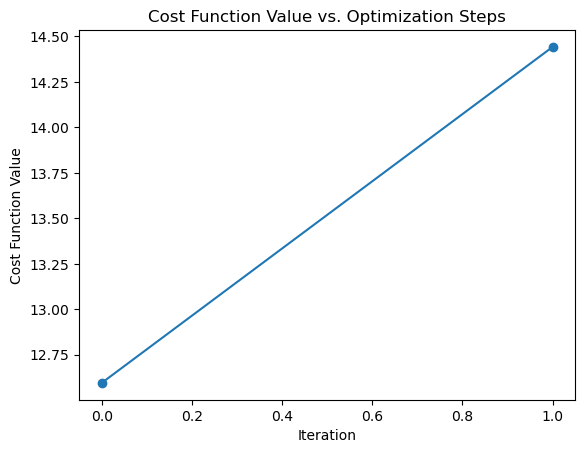

Optimization True
Optimal parameters: [-3.801e-02  9.433e-03  9.570e-02  4.630e-02  1.991e-03 -6.592e-02
  7.487e-04  1.778e-02 -1.955e-01 -9.003e-02  1.555e-04  1.313e-03
  3.461e-02  2.309e-03  1.386e-02 -1.080e-03  1.182e-04 -5.547e-03
 -6.376e-03 -1.953e-02 -1.835e-02]
Sum of parameters: -0.21607051956492834
Objective function value: 13.932913100093627


array([-3.801e-02,  9.433e-03,  9.570e-02,  4.630e-02,  1.991e-03,
       -6.592e-02,  7.487e-04,  1.778e-02, -1.955e-01, -9.003e-02,
        1.555e-04,  1.313e-03,  3.461e-02,  2.309e-03,  1.386e-02,
       -1.080e-03,  1.182e-04, -5.547e-03, -6.376e-03, -1.953e-02,
       -1.835e-02])

In [23]:

HIGHEST_DEGREE = 7
HIGHEST_ORDER = int((HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2)

init_temp_coeff = 1/10
T_range = 70
L_range = 30
N_particle = 200
survival_weight = 0.8

init_guess = np.concatenate([np.array([-0.035746,  0.005112,  0.083038,  0.046098,  0.008699, -0.042917,
        0.000947,  0.014932, -0.171657, -0.088658]),np.zeros(11)])
# init_guess = np.zeros(HIGHEST_ORDER)
init_cost = loss_func(init_guess, N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight)
print(f"initial cost = {init_cost}")

# Initialize a list to store the cost function values
cost_values = []
# Define the callback function
def callback(xk):
    cost_values.append(loss_func(xk,N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight))
# constraints = [{'type': 'eq', 'fun': lambda x: x[0]**2 + x[-1]**2}]
result = minimize(loss_func, init_guess, args=(N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight),\
                   method='Powell', options={'maxiter':500, 'disp': True}, callback=callback)

# Plot the cost function values
plt.plot(cost_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost Function Value')
plt.title('Cost Function Value vs. Optimization Steps')
plt.show()
print(f"Optimization {result.success}")
print("Optimal parameters:", result.x)
print("Sum of parameters:", np.sum(result.x))
print("Objective function value:", result.fun)

result.x

In [24]:
np.set_printoptions(precision=6)
result.x

array([-3.801169e-02,  9.432640e-03,  9.569924e-02,  4.630115e-02,
        1.990946e-03, -6.592048e-02,  7.486992e-04,  1.777523e-02,
       -1.955461e-01, -9.002804e-02,  1.554675e-04,  1.313341e-03,
        3.461495e-02,  2.308648e-03,  1.386111e-02, -1.079520e-03,
        1.181757e-04, -5.547493e-03, -6.375532e-03, -1.952931e-02,
       -1.835192e-02])

In [ ]:

HIGHEST_DEGREE = 7
HIGHEST_ORDER = int((HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2)

init_temp_coeff = 1/10
T_range = 70
L_range = 30
N_particle = 300
survival_weight = 0.8

init_guess = np.array([-3.801169e-02,  9.432640e-03,  9.569924e-02,  4.630115e-02,
        1.990946e-03, -6.592048e-02,  7.486992e-04,  1.777523e-02,
       -1.955461e-01, -9.002804e-02,  1.554675e-04,  1.313341e-03,
        3.461495e-02,  2.308648e-03,  1.386111e-02, -1.079520e-03,
        1.181757e-04, -5.547493e-03, -6.375532e-03, -1.952931e-02,
       -1.835192e-02])
# init_guess = np.zeros(HIGHEST_ORDER)
init_cost = loss_func(init_guess, N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight)
print(f"initial cost = {init_cost}")

# Initialize a list to store the cost function values
cost_values = []
# Define the callback function
def callback(xk):
    cost_values.append(loss_func(xk,N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight))
# constraints = [{'type': 'eq', 'fun': lambda x: x[0]**2 + x[-1]**2}]
result = minimize(loss_func, init_guess, args=(N_particle, HIGHEST_DEGREE, init_temp_coeff, T_range, L_range, survival_weight),\
                   method='Powell', options={'maxiter':500, 'disp': True}, callback=callback)

# Plot the cost function values
plt.plot(cost_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost Function Value')
plt.title('Cost Function Value vs. Optimization Steps')
plt.show()
print(f"Optimization {result.success}")
print("Optimal parameters:", result.x)
print("Sum of parameters:", np.sum(result.x))
print("Objective function value:", result.fun)

result.x

c:\Users\luyue\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luyue\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

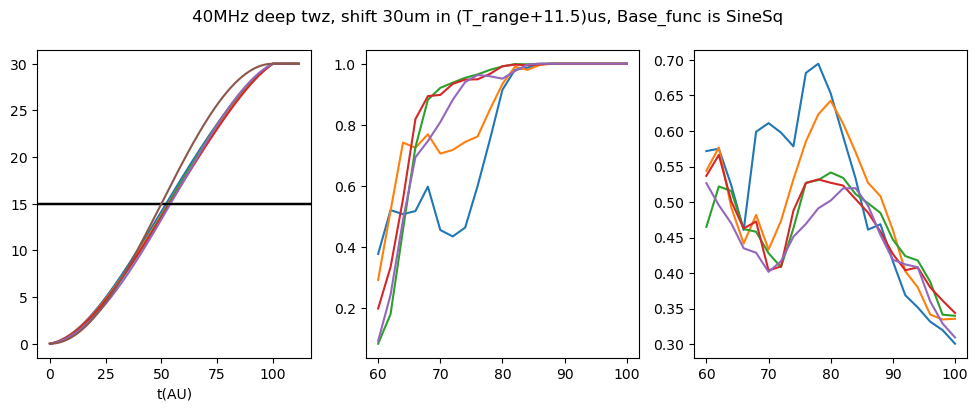

In [25]:
L_range = 30
plot_ramp = False
plot_trajectory = False
plot_histogram = False
N_particle = 1000
HIGHEST_DEGREE = 5
HIGHEST_ORDER = int((HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2)


T_range_list = np.arange(60,100.1,2) #us


sinc_order_list = [np.array([-0.042114, -0.000904,  0.090173,  0.045208,  0.052337, -0.050936,
        0.005302,  0.033061, -0.172302, -0.101846]),
        np.array([-0.049773,  0.005598,  0.106604,  0.050533,  0.029908, -0.068552,
        0.002012,  0.023714, -0.182471, -0.093313]),
        np.array([-0.035746,  0.005112,  0.083038,  0.046098,  0.008699, -0.042917,
        0.000947,  0.014932, -0.171657, -0.088658]),
        np.array([-3.801169e-02,  9.432640e-03,  9.569924e-02,  4.630115e-02,
        1.990946e-03, -6.592048e-02,  7.486992e-04,  1.777523e-02,
       -1.955461e-01, -9.002804e-02,  1.554675e-04,  1.313341e-03,
        3.461495e-02,  2.308648e-03,  1.386111e-02, -1.079520e-03,
        1.181757e-04, -5.547493e-03, -6.375532e-03, -1.952931e-02,
       -1.835192e-02])
                  ,np.array([-0.04400706,  0.00032466,  0.09661526,  0.04891758, -0.01302508,
       -0.06268795, -0.00110837, -0.00102826, -0.16357902, -0.06649545])
                # ,np.array([ 0.00949588,  0.00333944,  0.14430316, -0.05423573, -0.00319768, 0.01415184])
                  , np.zeros(HIGHEST_ORDER)
       ]
optimize_goal_list = ["60us",
    "65us",
    "70us",
    "70us (upto degree7)",
    "75us",
    # "80us",
    "none"
]
assert len(optimize_goal_list)==len(sinc_order_list)

phase_vec_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
t_vec_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
energies_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
survival_array = np.zeros((len(T_range_list),len(sinc_order_list)))
energy_avg_array = np.zeros((len(T_range_list),len(sinc_order_list)))
survived_energy_avg_array = np.zeros((len(T_range_list),len(sinc_order_list)))
energy_std_array = np.zeros((len(T_range_list),len(sinc_order_list)))

init_temp = E0/10

for ii,T_range in enumerate(T_range_list):
    t_list = np.linspace(0,T_range+T_delay,1000)
    for jj,expand_param in enumerate(sinc_order_list):
        HIGHEST_ORDER = len(expand_param)
        # print(HIGHEST_ORDER)
        ##################################################################
        phase_vec_list = []
        t_vec_list = []

        ###################### vectorized simulation #####################
        init_vec = np.random.normal(0, np.sqrt(init_temp/3), (6,N_particle))
        init_vec[0:2] = init_vec[0:2]/np.sqrt(4*E0/W**2)
        init_vec[3] = init_vec[3]/np.sqrt(2*E0/ZR**2)
        init_vec[3:6] = init_vec[3:6]/np.sqrt(M)

        real_E = np.stack((total_energy_t0(init_vec),) * 6, axis=-1).T
        normalize_factor = init_temp/(real_E+E0)
        # print(normalize_factor.shape)
        # comment out the next line if use boltzmann distribution
        init_vec *= np.sqrt(normalize_factor)  
        init_vec_flattened = init_vec.ravel()
        t_eval = t_list
        sol1=solve_ivp(time_derivative, [0,T_range+T_delay], init_vec_flattened,\
                        method='RK45', args=[expand_param], vectorized=True, t_eval=t_eval) #, maxes_step=.1)
        phase_vec_list = sol1.y.reshape(6,N_particle,-1).transpose(1, 0, 2)
        t_vec = sol1.t
        solutions = sol1.y.reshape(6,N_particle,-1) # [phase_vec_ind, particle_num, time]
        # energy_t = np.array([total_energy_movframe(sol1.t, solutions[:,ii] ,expand_param)/E0 for ii in range(N_particle)])
        # print(energy_t.shape)
        energy_list = np.array([total_energy_movframe(sol1.t[-1], phase_vec_list[jj,:,-1] ,expand_param)/E0 for jj in range(N_particle)])
        # print(energy_list.shape)
        # print(energy_list[0].shape)
        energies_array[ii,jj] = energy_list

        energy_std = np.std(energy_list)
        energy_avg = np.mean(energy_list) + 1
        survived_energy_avg = np.mean(energy_list[energy_list<0]) + 1

        survival = sum(energy_list<0)/len(energy_list)

        survived_energy_avg_array[ii,jj] = survived_energy_avg
        energy_std_array[ii,jj] = energy_std
        energy_avg_array[ii,jj] = energy_avg
        survival_array[ii,jj] = survival
        phase_vec_array[ii,jj] = phase_vec_list
        t_vec_array[ii,jj] = t_vec_list
        
        # print([ii,jj])
        if plot_ramp:
            fig, axes =plt.subplots(1,2,figsize=(8,3),sharex=False,sharey=False, squeeze=False)
            # plt.title(n)
            axes[0,0].axvline(T_range/2,color='k')
            axes[0,0].axhline(L_range/2,color='k')
            axes[0,0].plot(t_list, xc_func(t_list,expand_param))
            axes[0,0].plot(t_list, xc_func_base(t_list),ls="--",c='k')
            fig.suptitle(f"T_range = {T_range}, survival probability = {survival}, avg energy = {energy_avg}")
            axes[0,0].set_xlabel(expand_param)

            
            axes[0,1].axvline(-1,color='k')
            axes[0,1].axvline(0,color='k')
            axes[0,1].hist(energy_list, bins=30, edgecolor='black')
            # plt.title(f"survival probability = {survival}, avg energy = {energy_avg}")
            # plt.xlabel(expand_param)
            axes[0,1].set_xlabel('Final energy/E_0')
            plt.show()

        if plot_trajectory:
            n=N_particle//30
            # Create a figure and a set of subplots
            fig, axes = plt.subplots(2,3,figsize=(11,7),sharex='col',sharey=False)
            fig.suptitle(f"ramptime = {T_range:.1f}us - distance = {L_range:.1f}um - trap depth = {E0/(TRAP_DEPTH_MHz / RB_MASS):.2f}MHz - inital energy = {init_temp/(TRAP_DEPTH_MHz / RB_MASS):.2f}MHz")

            for ax in axes[0, :]:
                ax.sharey(axes[0, 0])


            color = cm.rainbow(np.linspace(0, 0.9, n))

            for i,phase_vec in enumerate(phase_vec_list[:n]):
                axes[0,0].plot(phase_vec[0],phase_vec[2],color=color[i],alpha=0.4)
                axes[0,0].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                axes[0,0].scatter(phase_vec[0,-1],phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,0].set_xlabel("x(um)")
                axes[0,0].set_ylabel("z(um)")
                axes[1,0].plot(phase_vec[0],t_vec,color=color[i],alpha=0.4)
                axes[1,0].set_xlabel("x(um)")
                axes[1,0].set_ylabel("t(us)")
                # axes[0,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),phase_vec[2],color=color[i],alpha=0.4)
                # axes[0,1].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                # axes[0,1].scatter(phase_vec[0,-1]-xc_func(t_vec[-1],expand_param),phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,1].scatter(phase_vec[0,-1]-xc_func(t_vec[-1],expand_param),phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),phase_vec[2],color=color[i],alpha=0.4)
                axes[0,1].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                axes[0,1].set_xlabel("x'(um)")
                axes[0,1].set_ylabel("z(um)")
                axes[1,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),t_vec,color=color[i],alpha=0.4)
                # axes[1,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),t_vec,color=color[i],alpha=0.4)
                axes[1,1].set_xlabel("x'(um)")
                axes[1,1].set_ylabel("t(us)")
                axes[0,2].plot(t_vec,phase_vec[2],color=color[i],alpha=0.4)
                axes[0,2].set_xlabel("t(us)")
                axes[0,2].set_ylabel("z(um)")
                # print(t_vec.shape)
                # print(phase_vec.shape)
                axes[1,2].plot(t_vec, [total_energy_movframe(t_vec[tt], phase_vec[:,tt], expand_param)/E0 for tt in range(len(t_vec))], color=color[i])
                
            axes[1,0].plot(xc_func(t_vec,expand_param), t_vec, color="k",ls=":")
            # axes[0,2].plot(t_vec, Zx_func(t_vec,expand_param),color="k",ls=":")
            # axes[0,2].plot(t_vec, Zx_func(t_vec,expand_param),color="k",ls=":")
            axes[1,2].axhline(0, color="k",ls=":")
            axes[1,2].axhline(-1, color="k",ls=":")
            axes[1,2].set_xlabel("t(us)")
            axes[1,2].set_ylabel("E/E0")
            
            # Define the center of the oval, width, and height
            center_x, center_y = 0,0
            width, height = 2*W,2*ZR
            # Create an ellipse patch
            ellipse = patches.Ellipse((center_x, center_y), width, height, edgecolor='black', facecolor='none')
            ellipse1 = patches.Ellipse((center_x+L_range, center_y), width, height, edgecolor='black', facecolor='none')
            ellipse2 = patches.Ellipse((center_x, center_y), width, height, edgecolor='black', facecolor='none')

            # Add the ellipse to the plot
            axes[0,0].add_patch(ellipse)
            axes[0,0].add_patch(ellipse1)
            # axes[0,0].axhline(Zx_func(T_range/2,expand_param),color="k",ls=":")
            # axes[0,0].plot(xc_func(t_vec,expand_param), Zx_func(t_vec,expand_param),color="k",ls=":")
            axes[0,1].add_patch(ellipse2)
            # axes[0,1].axhline(Zx_func(T_range/2,expand_param),color="k",ls=":")

            plt.tight_layout()
            plt.show()

        # energy_list = np.array([total_energy(t_vec, phase_vec_list[i],expand_param)[-1]/E0 for i in range(len(t_vec_list))])


        if plot_histogram:
            plt.figure()
            # plt.title(n)
            plt.axvline(-1,color='k')
            plt.axvline(0,color='k')
            plt.hist(energy_list, bins=30, edgecolor='black')
            plt.title(f"survival probability = {survival}, avg energy = {energy_avg}")
            # plt.xlabel(expand_param)
            plt.xlabel('Final energy/E_0')
            plt.show()
        
            
        #################################################################################
np.set_printoptions(precision=3)
fig, axes =plt.subplots(1,3,figsize=(12,4),sharex=False,sharey=False, squeeze=False)
fig.suptitle(f"40MHz deep twz, shift {L_range}um in (T_range+{T_delay:.1f})us, Base_func is SineSq")
for jj,expand_param in enumerate(sinc_order_list):  
    axes[0,0].axhline(L_range/2,color='k')
    axes[0,0].plot(t_list, xc_func(t_list,expand_param))
    # axes[0,0].plot(t_list, xc_func_base(t_list),ls="--",c='k')
    axes[0,0].set_xlabel('t(AU)')
    axes[0,2].plot(T_range_list, survived_energy_avg_array[:,jj], label=f"optimized for {optimize_goal_list[jj]} \n {expand_param}")
    axes[0,1].plot(T_range_list, survival_array[:,jj], label=f"{expand_param}")
# axes[0,0].legend()
axes[0,2].legend(loc=[1.05,0])
axes[0,1].set_title("survival rate")
axes[0,2].set_title("energy of survived atom/E_0")
axes[0,1].set_xlabel("T_range(um)")
axes[0,2].set_xlabel("T_range(um)")
axes[0,2].axhline(init_temp/E0, c='k', ls = ':')
plt.show()

In [26]:
optimize_goal_list = ["60us",
    "65us",
    "70us",
    "70us (upto degree7)",
    "75us",
    # "80us",
    "none"
]

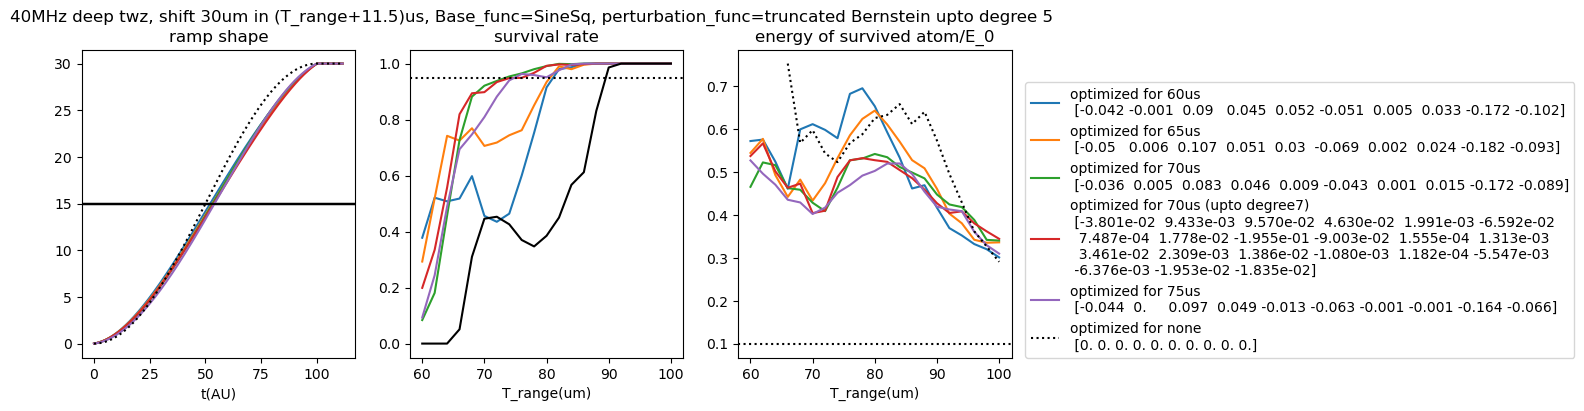

In [40]:
np.set_printoptions(precision=3)
fig, axes =plt.subplots(1,3,figsize=(12,4),sharex=False,sharey=False, squeeze=False)
fig.suptitle(f"40MHz deep twz, shift {L_range}um in (T_range+{T_delay:.1f})us, Base_func=SineSq, perturbation_func=truncated Bernstein upto degree 5")
for jj,expand_param in enumerate(sinc_order_list):  
    axes[0,0].axhline(L_range/2,color='k')
    if optimize_goal_list[jj] == "none":
        axes[0,0].plot(t_list, xc_func(t_list,expand_param),c='k',ls=":")
        axes[0,2].plot(T_range_list, survived_energy_avg_array[:,jj], label=f"optimized for {optimize_goal_list[jj]} \n {expand_param}",c='k',ls=":")
        axes[0,1].plot(T_range_list, survival_array[:,jj], label=f"{expand_param}",c='k')
    else:
        axes[0,0].plot(t_list, xc_func(t_list,expand_param))
        axes[0,2].plot(T_range_list, survived_energy_avg_array[:,jj], label=f"optimized for {optimize_goal_list[jj]} \n {expand_param}")
        axes[0,1].plot(T_range_list, survival_array[:,jj], label=f"{expand_param}")
    # axes[0,0].plot(t_list, xc_func_base(t_list),ls="--",c='k')
axes[0,0].set_xlabel('t(AU)')
axes[0,2].legend(loc=[1.05,0])
axes[0,1].set_title("survival rate")
axes[0,1].axhline(0.95,c='k',ls=":")
axes[0,0].set_title("ramp shape")
axes[0,2].set_title("energy of survived atom/E_0")
axes[0,1].set_xlabel("T_range(um)")
axes[0,2].set_xlabel("T_range(um)")
axes[0,2].axhline(init_temp/E0, c='k', ls = ':')
plt.show()

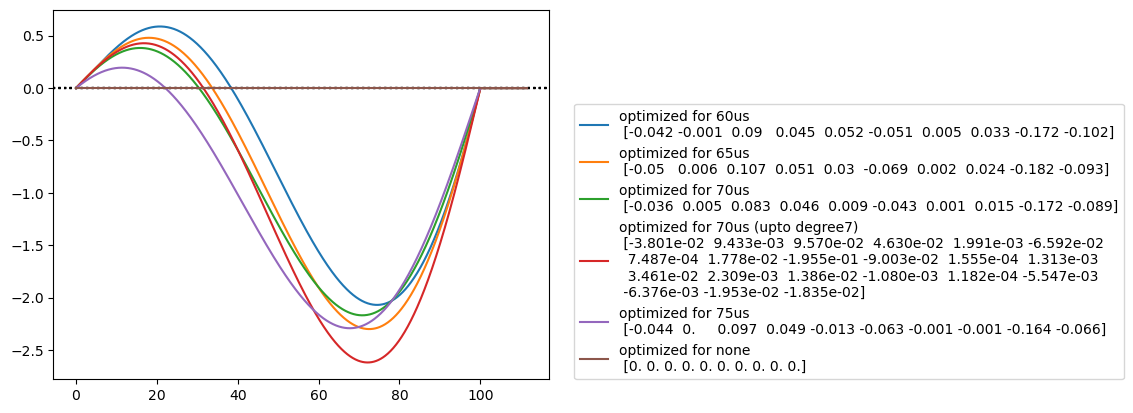

In [41]:
for jj,expand_param in enumerate(sinc_order_list):  
    plt.axhline(0,color='k',ls=":")
    plt.plot(t_list, xc_func(t_list,expand_param)-xc_func_base(t_list),
                    label=f"optimized for {optimize_goal_list[jj]} \n {expand_param}")
plt.legend(loc=(1.05,0))

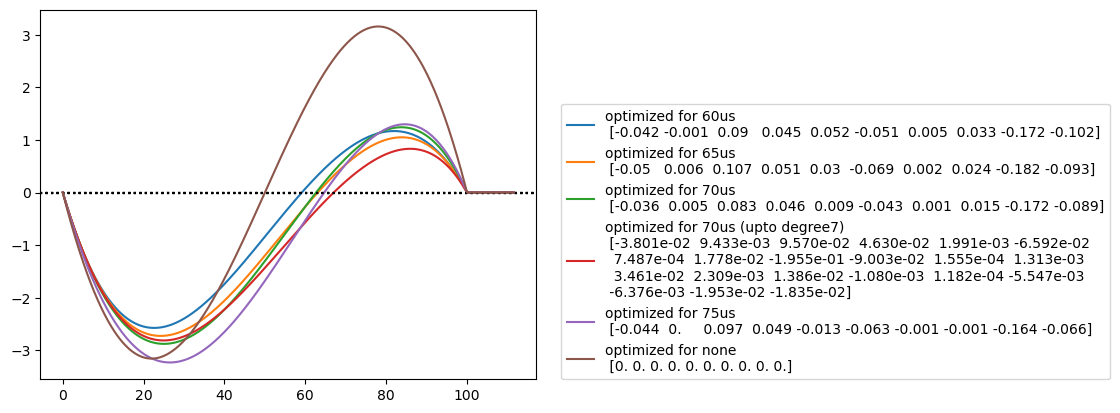

In [37]:
for jj,expand_param in enumerate(sinc_order_list):  
    plt.axhline(0,color='k',ls=":")
    plt.plot(t_list, xc_func(t_list,expand_param)-xc_func_linear_base(t_list),
                    label=f"optimized for {optimize_goal_list[jj]} \n {expand_param}")
plt.legend(loc=(1.05,0))

In [ ]:
L_range = 30
plot_ramp = True
plot_trajectory = True
plot_histogram = False
N_particle = 1000
HIGHEST_DEGREE = 5
HIGHEST_ORDER = int((HIGHEST_DEGREE-1)*HIGHEST_DEGREE/2)


T_range_list = np.arange(70,100.1,1) #us


sinc_order_list = [
        np.array([-0.035746,  0.005112,  0.083038,  0.046098,  0.008699, -0.042917,
        0.000947,  0.014932, -0.171657, -0.088658]),
        np.array([-3.801169e-02,  9.432640e-03,  9.569924e-02,  4.630115e-02,
        1.990946e-03, -6.592048e-02,  7.486992e-04,  1.777523e-02,
       -1.955461e-01, -9.002804e-02,  1.554675e-04,  1.313341e-03,
        3.461495e-02,  2.308648e-03,  1.386111e-02, -1.079520e-03,
        1.181757e-04, -5.547493e-03, -6.375532e-03, -1.952931e-02,
       -1.835192e-02])]
optimize_goal_list = [
    "70us (upto degree7)",
    "75us"
]
assert len(optimize_goal_list)==len(sinc_order_list)

phase_vec_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
t_vec_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
energies_array = np.empty((len(T_range_list),len(sinc_order_list)), dtype=object)
survival_array = np.zeros((len(T_range_list),len(sinc_order_list)))
energy_avg_array = np.zeros((len(T_range_list),len(sinc_order_list)))
survived_energy_avg_array = np.zeros((len(T_range_list),len(sinc_order_list)))
energy_std_array = np.zeros((len(T_range_list),len(sinc_order_list)))

init_temp = E0/10

for ii,T_range in enumerate(T_range_list):
    t_list = np.linspace(0,T_range+T_delay,1000)
    for jj,expand_param in enumerate(sinc_order_list):
        HIGHEST_ORDER = len(expand_param)
        # print(HIGHEST_ORDER)
        ##################################################################
        phase_vec_list = []
        t_vec_list = []

        ###################### vectorized simulation #####################
        init_vec = np.random.normal(0, np.sqrt(init_temp/3), (6,N_particle))
        init_vec[0:2] = init_vec[0:2]/np.sqrt(4*E0/W**2)
        init_vec[3] = init_vec[3]/np.sqrt(2*E0/ZR**2)
        init_vec[3:6] = init_vec[3:6]/np.sqrt(M)

        real_E = np.stack((total_energy_t0(init_vec),) * 6, axis=-1).T
        normalize_factor = init_temp/(real_E+E0)
        # print(normalize_factor.shape)
        # comment out the next line if use boltzmann distribution
        init_vec *= np.sqrt(normalize_factor)  
        init_vec_flattened = init_vec.ravel()
        t_eval = t_list
        sol1=solve_ivp(time_derivative, [0,T_range+T_delay], init_vec_flattened,\
                        method='RK45', args=[expand_param], vectorized=True, t_eval=t_eval) #, maxes_step=.1)
        phase_vec_list = sol1.y.reshape(6,N_particle,-1).transpose(1, 0, 2)
        t_vec = sol1.t
        solutions = sol1.y.reshape(6,N_particle,-1) # [phase_vec_ind, particle_num, time]
        # energy_t = np.array([total_energy_movframe(sol1.t, solutions[:,ii] ,expand_param)/E0 for ii in range(N_particle)])
        # print(energy_t.shape)
        energy_list = np.array([total_energy_movframe(sol1.t[-1], phase_vec_list[jj,:,-1] ,expand_param)/E0 for jj in range(N_particle)])
        # print(energy_list.shape)
        # print(energy_list[0].shape)
        energies_array[ii,jj] = energy_list

        energy_std = np.std(energy_list)
        energy_avg = np.mean(energy_list) + 1
        survived_energy_avg = np.mean(energy_list[energy_list<0]) + 1

        survival = sum(energy_list<0)/len(energy_list)

        survived_energy_avg_array[ii,jj] = survived_energy_avg
        energy_std_array[ii,jj] = energy_std
        energy_avg_array[ii,jj] = energy_avg
        survival_array[ii,jj] = survival
        phase_vec_array[ii,jj] = phase_vec_list
        t_vec_array[ii,jj] = t_vec_list
        
        # print([ii,jj])
        if plot_ramp:
            fig, axes =plt.subplots(1,2,figsize=(8,3),sharex=False,sharey=False, squeeze=False)
            # plt.title(n)
            axes[0,0].axvline(T_range/2,color='k')
            axes[0,0].axhline(L_range/2,color='k')
            axes[0,0].plot(t_list, xc_func(t_list,expand_param))
            axes[0,0].plot(t_list, xc_func_base(t_list),ls="--",c='k')
            fig.suptitle(f"T_range = {T_range}, survival probability = {survival}, avg energy = {energy_avg}")
            axes[0,0].set_xlabel(expand_param)

            
            axes[0,1].axvline(-1,color='k')
            axes[0,1].axvline(0,color='k')
            axes[0,1].hist(energy_list, bins=30, edgecolor='black')
            # plt.title(f"survival probability = {survival}, avg energy = {energy_avg}")
            # plt.xlabel(expand_param)
            axes[0,1].set_xlabel('Final energy/E_0')
            plt.show()

        if plot_trajectory:
            n=N_particle//30
            # Create a figure and a set of subplots
            fig, axes = plt.subplots(2,3,figsize=(11,7),sharex='col',sharey=False)
            fig.suptitle(f"ramptime = {T_range:.1f}us - distance = {L_range:.1f}um - trap depth = {E0/(TRAP_DEPTH_MHz / RB_MASS):.2f}MHz - inital energy = {init_temp/(TRAP_DEPTH_MHz / RB_MASS):.2f}MHz")

            for ax in axes[0, :]:
                ax.sharey(axes[0, 0])


            color = cm.rainbow(np.linspace(0, 0.9, n))

            for i,phase_vec in enumerate(phase_vec_list[:n]):
                axes[0,0].plot(phase_vec[0],phase_vec[2],color=color[i],alpha=0.4)
                axes[0,0].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                axes[0,0].scatter(phase_vec[0,-1],phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,0].set_xlabel("x(um)")
                axes[0,0].set_ylabel("z(um)")
                axes[1,0].plot(phase_vec[0],t_vec,color=color[i],alpha=0.4)
                axes[1,0].set_xlabel("x(um)")
                axes[1,0].set_ylabel("t(us)")
                # axes[0,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),phase_vec[2],color=color[i],alpha=0.4)
                # axes[0,1].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                # axes[0,1].scatter(phase_vec[0,-1]-xc_func(t_vec[-1],expand_param),phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,1].scatter(phase_vec[0,-1]-xc_func(t_vec[-1],expand_param),phase_vec[2,-1],color=color[i],marker="x",s=80)
                axes[0,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),phase_vec[2],color=color[i],alpha=0.4)
                axes[0,1].scatter(phase_vec[0,0],phase_vec[2,0],color=color[i],marker="+",s=80)
                axes[0,1].set_xlabel("x'(um)")
                axes[0,1].set_ylabel("z(um)")
                axes[1,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),t_vec,color=color[i],alpha=0.4)
                # axes[1,1].plot(phase_vec[0]-xc_func(t_vec,expand_param),t_vec,color=color[i],alpha=0.4)
                axes[1,1].set_xlabel("x'(um)")
                axes[1,1].set_ylabel("t(us)")
                axes[0,2].plot(t_vec,phase_vec[2],color=color[i],alpha=0.4)
                axes[0,2].set_xlabel("t(us)")
                axes[0,2].set_ylabel("z(um)")
                # print(t_vec.shape)
                # print(phase_vec.shape)
                axes[1,2].plot(t_vec, [total_energy_movframe(t_vec[tt], phase_vec[:,tt], expand_param)/E0 for tt in range(len(t_vec))], color=color[i])
                
            axes[1,0].plot(xc_func(t_vec,expand_param), t_vec, color="k",ls=":")
            # axes[0,2].plot(t_vec, Zx_func(t_vec,expand_param),color="k",ls=":")
            # axes[0,2].plot(t_vec, Zx_func(t_vec,expand_param),color="k",ls=":")
            axes[1,2].axhline(0, color="k",ls=":")
            axes[1,2].axhline(-1, color="k",ls=":")
            axes[1,2].set_xlabel("t(us)")
            axes[1,2].set_ylabel("E/E0")
            
            # Define the center of the oval, width, and height
            center_x, center_y = 0,0
            width, height = 2*W,2*ZR
            # Create an ellipse patch
            ellipse = patches.Ellipse((center_x, center_y), width, height, edgecolor='black', facecolor='none')
            ellipse1 = patches.Ellipse((center_x+L_range, center_y), width, height, edgecolor='black', facecolor='none')
            ellipse2 = patches.Ellipse((center_x, center_y), width, height, edgecolor='black', facecolor='none')

            # Add the ellipse to the plot
            axes[0,0].add_patch(ellipse)
            axes[0,0].add_patch(ellipse1)
            # axes[0,0].axhline(Zx_func(T_range/2,expand_param),color="k",ls=":")
            # axes[0,0].plot(xc_func(t_vec,expand_param), Zx_func(t_vec,expand_param),color="k",ls=":")
            axes[0,1].add_patch(ellipse2)
            # axes[0,1].axhline(Zx_func(T_range/2,expand_param),color="k",ls=":")

            plt.tight_layout()
            plt.show()

        # energy_list = np.array([total_energy(t_vec, phase_vec_list[i],expand_param)[-1]/E0 for i in range(len(t_vec_list))])


        if plot_histogram:
            plt.figure()
            # plt.title(n)
            plt.axvline(-1,color='k')
            plt.axvline(0,color='k')
            plt.hist(energy_list, bins=30, edgecolor='black')
            plt.title(f"survival probability = {survival}, avg energy = {energy_avg}")
            # plt.xlabel(expand_param)
            plt.xlabel('Final energy/E_0')
            plt.show()
        
            
        #################################################################################
np.set_printoptions(precision=3)
fig, axes =plt.subplots(1,3,figsize=(12,4),sharex=False,sharey=False, squeeze=False)
fig.suptitle(f"40MHz deep twz, shift {L_range}um in (T_range+{T_delay:.1f})us, Base_func is SineSq")
for jj,expand_param in enumerate(sinc_order_list):  
    axes[0,0].axhline(L_range/2,color='k')
    axes[0,0].plot(t_list, xc_func(t_list,expand_param))
    # axes[0,0].plot(t_list, xc_func_base(t_list),ls="--",c='k')
    axes[0,0].set_xlabel('t(AU)')
    axes[0,2].plot(T_range_list, survived_energy_avg_array[:,jj], label=f"optimized for {optimize_goal_list[jj]} \n {expand_param}")
    axes[0,1].plot(T_range_list, survival_array[:,jj], label=f"{expand_param}")
# axes[0,0].legend()
axes[0,2].legend(loc=[1.05,0])
axes[0,1].set_title("survival rate")
axes[0,2].set_title("energy of survived atom/E_0")
axes[0,1].set_xlabel("T_range(um)")
axes[0,2].set_xlabel("T_range(um)")
axes[0,2].axhline(init_temp/E0, c='k', ls = ':')
plt.show()

In [36]:

########################## for linear ramp base ###########################
def xc_func_linear_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, x * L_range,         # If 0 < x < 1, return middle part
                    L_range))                # If x >= 1, return end part
def dxc_func_linear_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, 1 * (L_range/T_range),         # If 0 < x < 1, return middle part
                    0))                # If x >= 1, return end part
def Ac_func_linear_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, x**2 / 2 * T_range*L_range,         # If 0 < x < 1, return middle part
                    (x - 0.5) * T_range*L_range))                # If x >= 1, return end part

########################## for piecewise quadratic base ###########################
def xc_func_linear_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, x * L_range,         # If 0 < x < 1, return middle part
                    L_range))                # If x >= 1, return end part
def dxc_func_linear_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, 1 * (L_range/T_range),         # If 0 < x < 1, return middle part
                    0))                # If x >= 1, return end part
def Ac_func_linear_base(t):
    x = t/T_range
    return np.where(x <= 0, 0,            # If x <= 0, return 0
           np.where(x < 1, x**2 / 2 * T_range*L_range,         # If 0 < x < 1, return middle part
                    (x - 0.5) * T_range*L_range))                # If x >= 1, return end part

